# 🎮 Gaming Sentiment Analysis & Power BI Dashboard

## Overview
This comprehensive project analyzes sentiment trends across popular Steam games using advanced NLP techniques and creates interactive Power BI dashboards for business intelligence insights.

### Key Features:
- **Multi-Game Analysis**: CS:GO, Dota 2, Apex Legends, PUBG, and more
- **Advanced Sentiment Analysis**: TextBlob + Transformer models
- **Time Series Analysis**: Trend detection and seasonality
- **Power BI Integration**: Automated data export for dashboard creation
- **Interactive Visualizations**: Plotly charts and statistical insights

### Methodology:
1. Web scraping Steam reviews using BeautifulSoup
2. Text preprocessing and cleaning with NLTK
3. Sentiment classification using multiple approaches
4. Statistical analysis and trend detection
5. Data export for Power BI dashboards

In [ ]:
# Enhanced Import Section with Power BI Integration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Set up styling
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 100)

print("✅ Enhanced imports loaded successfully!")
print("📊 Ready for comprehensive gaming sentiment analysis and Power BI integration")

In [1]:
# Data Collection and Web Scraping
from datetime import datetime as dt
import requests
import pandas as pd
from bs4 import BeautifulSoup
import json
import random

current_year = dt.today().year
headers = {'User-Agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_6) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/13.1.2 Safari/605.1.15'}

def get_review_count(id):
    """Return total number of reviews of default language.

    Args:
        id (int or str): Game id.

    Returns:
        int: Number of reviews.
    """    

    url = 'https://store.steampowered.com/app/' + str(id)
    html = requests.get(url, headers=headers).text
    soup = BeautifulSoup(html, 'html.parser')
    count = soup.find('label', {'for': 'review_language_mine'}).span.text
    count = count.strip('()').replace(',','')
    return int(count)

def search_game_id(search_term, all_results=False): 
    """Return Dataframe of game ids of the search term from Steam's search result page.

    Args:
        search_term (str): Game name to search.
        all_results (bool, optional): Whether to return all games results of the search term or the top one result. Defaults to False.

    Returns:
        Dataframe: Dataframe with two columns "game" and "id".
    """    
    page = 1
    game = []
    id = []
    if not all_results:
        url = f'https://store.steampowered.com/search/?category1=998&page={page}&term={search_term}'
        html = requests.get(url, headers=headers).text
        soup = BeautifulSoup(html, 'html.parser')
        search_results = soup.find(class_='search_result_row')
        game = search_results.find('span', class_='title').text
        id = search_results['data-ds-appid']
        return pd.DataFrame({
            'game':[game],
            'id':[id]
        })
    else:
        while True:
            url = f'https://store.steampowered.com/search/?category1=998&page={page}&term={search_term}'
            html = requests.get(url, headers=headers).text
            soup = BeautifulSoup(html, 'html.parser')
            search_results = soup.find_all(class_='search_result_row')
            if not search_results:
                break
            
            title = [result.find('span', class_='title').text for result in search_results]
            appid = [result['data-ds-appid'] for result in search_results]
            game.extend(title)
            id.extend(appid)
            page += 1
        
        return pd.DataFrame({
            'game':game,
            'id':id
        })

def get_game_ids(n, filter='topsellers'):
    """Return Dataframe of n games' ids from Steam's search result page.

    Args:
        n (int): number of games to collect.
        filter (str, optional): filter for search results. Defaults to 'topsellers'.

    Returns:
        Dataframe: Dataframe with two columns "game" and "id".
    """    
    page = 1
    game = []
    id = []
    while len(game) < n:
        url = f'https://store.steampowered.com/search/?category1=998&page={page}&filter={filter}'
        html = requests.get(url, headers=headers).text
        soup = BeautifulSoup(html, 'html.parser')
        search_results = soup.find_all(class_='search_result_row')
        if not search_results:
            break
        
        title = [result.find('span', class_='title').text for result in search_results]
        appid = [result['data-ds-appid'] for result in search_results]
        game.extend(title)
        id.extend(appid)
        page += 1
    num = min(n, len(game))
    return pd.DataFrame({
        'game':game[:num],
        'id':id[:num]
    })

def clean_date(date):
    """Helper function to clean review date pulled from Steam's review page for a game.

    Strip 'Posted: ' from the date string.
    Add current year to date if review was posted in the current year.

        Typical usage example:
        >>> clean_date('Posted: May 6')
        'May 6, 2021'

    Args:
        date (str): Date string pulled from review page.

    Returns:
        str: Clean date string.
    """    
    date = date.split(' ',1)[1]
    try: 
        dt.strptime(date,'%B %d, %Y')
        pass
    except ValueError:
        date += ', ' +str(current_year)
    return date

def get_game_review(id, language='default', max_reviews=100):
    """Collect a limited number of reviews for a given game.

    Args:
        id (int or str): Game id 
        language (str, optional): The language in which to get the reviews. Defaults to 'default', 
            which is the default language of your Steam account.
        max_reviews (int, optional): Maximum number of reviews to collect. Defaults to 100.

    Returns:
        Dataframe: Dataframe for reviews with the following columns:

        | name                | description                                           | dtype   |
        |---------------------|-------------------------------------------------------|---------|
        | user                | user name of the review                               | object  |
        | playtime            | total playtime (in hours) the user spent on this game | float64 |
        | user_link           | user's profile page url                               | object  |
        | post_date           | review's post date                                    | object  |
        | helpfulness         | number of people found this review helpful            | int64   |
        | review              | review content                                        | object  |
        | recommend           | whether the user recommend the game                   | object  |
        | early_access_review | whether this is an early access review                | object  |
    """    
    user_name_list = []
    hour_list = []
    user_link_list = []
    post_date_list = []
    helpful_list = []
    comment_list = []
    title_list = []
    early_access_list = []

    cursor = ''
    i = 0
    total_reviews = 0
    while total_reviews < max_reviews:
        url=f'https://steamcommunity.com/app/{id}/homecontent/'
        params = {
            'userreviewsoffset': i * 10,
            'p': i + 1,
            'workshopitemspage': i + 1,
            'readytouseitemspage': i + 1,
            'mtxitemspage': i + 1,
            'itemspage': i + 1,
            'screenshotspage': i + 1,
            'videospage': i + 1,
            'artpage': i + 1,
            'allguidepage': i + 1,
            'webguidepage': i + 1,
            'integeratedguidepage': i + 1,
            'discussionspage': i + 1,
            'numperpage': 10,
            'browsefilter': 'toprated',
            'appid': id,
            'appHubSubSection': 10,
            'l': 'english',
            'filterLanguage': language,
            'searchText': '',
            'forceanon': 1,
            'maxInappropriateScore': 50,
        }
        if i > 0:
            params['userreviewscursor'] = cursor
        html = requests.get(url, headers=headers, params=params).text
        soup = BeautifulSoup(html, 'html.parser')
        reviews = soup.find_all('div', {'class': 'apphub_Card'})
        
        if not reviews:
            break
        
        users = [review.find('div', {'class': 'apphub_CardContentAuthorName'}) for review in reviews]
        user_name = [user.find('a').text for user in users]
        user_link = [user.find('a').attrs['href'] for user in users]
        title = [review.find('div', {'class': 'title'}).text for review in reviews]
        hour = [float(review.find('div', {'class': 'hours'}).text.replace(',', '').split(' ')[0]) if review.find('div', {'class': 'hours'}) 
                else float('nan') for review in reviews]
        helpful = [review.find('div',{'class': 'found_helpful'}).get_text(strip=True).replace(',', '').split(' ')[0] for review in reviews]
        helpful = [0 if num == 'No' else int(num) for num in helpful]
        comment_section = [review.find('div', {'class': 'apphub_CardTextContent'}) for review in reviews]
        raw_post_date = [x.find('div',{'class':'date_posted'}).get_text(strip=True) for x in comment_section]
        post_date = [clean_date(date) for date in raw_post_date]
        comment = [''.join(review.find_all(string=True, recursive=False)).strip() for review in comment_section]
        early_access = [x.find('div',{'class': 'early_access_review'}).text if x.find('div',{'class': 'early_access_review'}) 
                        else None for x in comment_section]
        # A response includes a ‘userreviewscursor’ attribute, marking which review your request completed on. 
        # Adding same cursor in the next request’s parameters to get the next 10 reviews. 
        # Otherwise it will return the same 10 reivews as last request.
        cursor = soup.find_all('form')[0].find('input',{'name': 'userreviewscursor'})['value']

        user_name_list.extend(user_name)
        hour_list.extend(hour)
        user_link_list.extend(user_link)
        post_date_list.extend(post_date)
        helpful_list.extend(helpful)
        comment_list.extend(comment)
        title_list.extend(title)
        early_access_list.extend(early_access)
        i += 1
        total_reviews += len(reviews)

        if total_reviews >= max_reviews:
            break

    review_df = pd.DataFrame({
        'user': user_name_list[:max_reviews],
        'playtime': hour_list[:max_reviews],
        'user_url': user_link_list[:max_reviews],
        'post_date': post_date_list[:max_reviews],
        'helpfulness': helpful_list[:max_reviews],
        'review': comment_list[:max_reviews],
        'recommend': title_list[:max_reviews],
        'early_access_review': early_access_list[:max_reviews]
    })
    return review_df


In [2]:
def get_steam_reviews(game_names, pages=10, max_reviews_per_game=100):
    all_reviews = {}
    for game_name in game_names:
        game_id_df = search_game_id(game_name)
        if game_id_df.empty:
            print(f"No game found for '{game_name}'. Skipping...")
            continue
        game_id = game_id_df.iloc[0]['id']
        reviews_df = get_game_review(game_id, language='english', max_reviews=max_reviews_per_game)
        reviews = [
            {
                'review': row['review'],
                'date': pd.to_datetime(row['post_date'])
            }
            for _, row in reviews_df.iterrows()
        ]
        all_reviews[game_name] = reviews
    return all_reviews

# Run Data Collection
if __name__ == "__main__":
    # Example: Collect reviews for multiple popular Steam games
    steam_game_names = [
        "Counter-Strike: Global Offensive",
        "Dota 2",
        "Apex Legends",
        "PUBG: Battlegrounds",
        "Demonsomnia",
        "Bodycam",
        "Grand Theft Auto V"
    ]
    reviews = get_steam_reviews(steam_game_names, max_reviews_per_game=300)
    for game_name, game_reviews in reviews.items():
        print(f"Collected {len(game_reviews)} reviews for game '{game_name}'.")

Collected 300 reviews for game 'Counter-Strike: Global Offensive'.
Collected 300 reviews for game 'Dota 2'.
Collected 300 reviews for game 'Apex Legends'.
Collected 300 reviews for game 'PUBG: Battlegrounds'.
Collected 115 reviews for game 'Demonsomnia'.
Collected 300 reviews for game 'Bodycam'.
Collected 300 reviews for game 'Grand Theft Auto V'.


In [3]:
import re
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

# Download necessary resources
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('omw-1.4')

def preprocess_reviews(reviews):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    cleaned_reviews = {}

    # POS tags to keep: nouns, verbs, adjectives, and adverbs
    allowed_pos_tags = {'NN', 'NNS', 'NNP', 'NNPS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS'}

    for game_name, game_reviews in reviews.items():
        cleaned_game_reviews = []
        for review_data in game_reviews:
            review = review_data['review']
            # Convert to lowercase
            review = review.lower()
            # Remove special characters and punctuation
            review = re.sub(r'[^a-zA-Z0-9\s]', '', review)
            # Remove extra spaces
            review = re.sub(r'\s+', ' ', review).strip()
            # Tokenize review
            tokens = word_tokenize(review)
            # Remove stopwords
            tokens = [word for word in tokens if word not in stop_words]
            # POS tagging
            pos_tags = pos_tag(tokens)
            # Keep only words with relevant POS tags
            tokens = [word for word, tag in pos_tags if tag in allowed_pos_tags]
            # Lemmatize words to their base form
            tokens = [lemmatizer.lemmatize(word) for word in tokens]
            # Join tokens back into a cleaned review
            cleaned_review = ' '.join(tokens)
            # Add cleaned review along with the date
            cleaned_game_reviews.append({'review': cleaned_review, 'date': review_data['date']})
        cleaned_reviews[game_name] = cleaned_game_reviews

    return cleaned_reviews

# Run Data Preprocessing
if __name__ == "__main__":
    # Example: Clean the collected reviews
    cleaned_reviews = preprocess_reviews(reviews)
    for game_name, game_cleaned_reviews in cleaned_reviews.items():
        print(f"Cleaned {len(game_cleaned_reviews)} reviews for game '{game_name}'.")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shreyas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\shreyas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\shreyas\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shreyas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\shreyas\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Cleaned 300 reviews for game 'Counter-Strike: Global Offensive'.
Cleaned 300 reviews for game 'Dota 2'.
Cleaned 300 reviews for game 'Apex Legends'.
Cleaned 300 reviews for game 'PUBG: Battlegrounds'.
Cleaned 115 reviews for game 'Demonsomnia'.
Cleaned 300 reviews for game 'Bodycam'.
Cleaned 300 reviews for game 'Grand Theft Auto V'.


In [4]:
# Sentiment Analysis
from textblob import TextBlob
from collections import Counter

def sentiment_analysis(reviews):
    sentiments = {}
    for game_name, game_reviews in reviews.items():
        game_sentiments = []
        for review_data in game_reviews:
            analysis = TextBlob(review_data['review'])
            # Classify sentiment as positive, negative, or neutral
            if analysis.sentiment.polarity > 0:
                sentiment = 'positive'
            elif analysis.sentiment.polarity < 0:
                sentiment = 'negative'
            else:
                sentiment = 'neutral'
            game_sentiments.append({'sentiment': sentiment, 'date': review_data['date'], 'review': review_data['review']})
        sentiments[game_name] = game_sentiments

        # Smooth out sentiment fluctuations by removing short-term minority classes
        smoothed_sentiments = []
        window_size = 3  # A window of three reviews for context-based smoothing
        for i in range(len(game_sentiments)):
            current_sentiment = game_sentiments[i]['sentiment']
            surrounding_sentiments = [s['sentiment'] for s in game_sentiments[max(0, i - window_size):min(len(game_sentiments), i + window_size + 1)]]
            
            # Count sentiment frequencies within the window
            sentiment_counts = Counter(surrounding_sentiments)
            
            # Keep the current sentiment if it's the majority sentiment in the window, or if it's neutral
            if sentiment_counts[current_sentiment] >= max(sentiment_counts.values()) or current_sentiment == 'neutral':
                smoothed_sentiments.append(game_sentiments[i])
            else:
                # Replace the sentiment with the majority sentiment within the window
                majority_sentiment = max(sentiment_counts, key=sentiment_counts.get)
                smoothed_sentiments.append({'sentiment': majority_sentiment, 'date': game_sentiments[i]['date'], 'review': game_sentiments[i]['review']})
        
        sentiments[game_name] = smoothed_sentiments

    return sentiments

# Run Sentiment Analysis
if __name__ == "__main__":
    # Example: Apply sentiment analysis to cleaned reviews
    sentiments = sentiment_analysis(cleaned_reviews)
    for game_name, game_sentiments in sentiments.items():
        print(f"Sentiment analysis completed for game '{game_name}'. Example sentiments: {game_sentiments[:5]}")

Sentiment analysis completed for game 'Counter-Strike: Global Offensive'. Example sentiments: [{'sentiment': 'neutral', 'date': Timestamp('2023-03-31 00:00:00'), 'review': ''}, {'sentiment': 'neutral', 'date': Timestamp('2023-10-11 00:00:00'), 'review': ''}, {'sentiment': 'neutral', 'date': Timestamp('2020-12-10 00:00:00'), 'review': 'year playing didnt improve skill ingamehowever learned new language skill curse russian brazilian portuguesealso tolerance level guttural scream loud sound increasednow cry child longer make feel better singing sweet traditional song culture dark eye girl ipanemain conclusion counter strike transformed better father better person addition making patient tolerant hateful people trained language culturesbetter psychiatric therapy'}, {'sentiment': 'neutral', 'date': Timestamp('2023-03-14 00:00:00'), 'review': 'see guyshoot himmiss shothe turn aroundkills shotexit csgo1010'}, {'sentiment': 'neutral', 'date': Timestamp('2022-06-28 00:00:00'), 'review': 'commun

In [5]:
# Preparing DataFrame for Temporal Analysis

def prepare_dataframe(sentiments):
    data = []
    for game_name, game_reviews in sentiments.items():
        for review_data in game_reviews:
            sentiment_score = 1 if review_data['sentiment'] == 'positive' else (-1 if review_data['sentiment'] == 'negative' else 0)
            data.append({
                'date': review_data['date'],
                'sentiment': sentiment_score,
                'game_name': game_name
            })
    return pd.DataFrame(data)

# Create DataFrame from sentiment analysis results
if __name__ == "__main__":
    reviews_df = prepare_dataframe(sentiments)



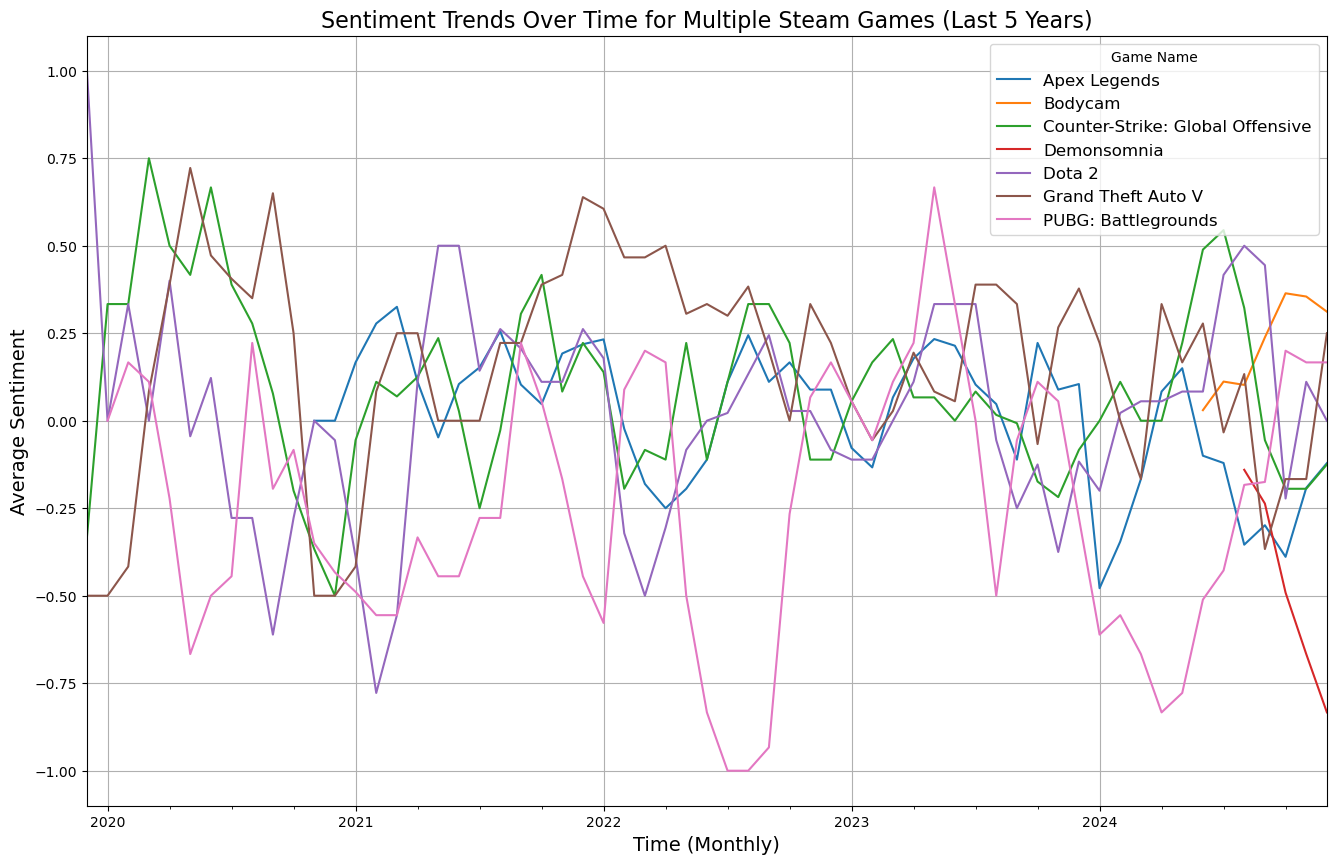

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# Analyzing sentiment trends over time with smoothing
def analyze_sentiment_trends(reviews_df):
    # Convert 'date' to datetime
    reviews_df['date'] = pd.to_datetime(reviews_df['date'])
    
    # Filter data for the latest 6 years
    recent_reviews = reviews_df[reviews_df['date'] >= (pd.Timestamp.now() - pd.DateOffset(years=5))]
    
    # Group by game name and month, calculate mean sentiment
    sentiment_trends = recent_reviews.groupby([
        recent_reviews['game_name'], 
        recent_reviews['date'].dt.to_period('M')
    ])['sentiment'].mean().unstack(level=0)
    
    # Apply a rolling average to smooth the data (e.g., 3-month window)
    smoothed_trends = sentiment_trends.rolling(window=3, min_periods=1).mean()
    
    # Plot sentiment trends over time
    plt.figure(figsize=(16, 10))  # Larger figure size
    smoothed_trends.plot(kind='line', ax=plt.gca())  # Use current axes for more control
    plt.title('Sentiment Trends Over Time for Multiple Steam Games (Last 5 Years)', fontsize=16)
    plt.xlabel('Time (Monthly)', fontsize=14)
    plt.ylabel('Average Sentiment', fontsize=14)
    plt.legend(title='Game Name', fontsize=12)
    plt.grid(True)
    plt.show()

# Run Temporal Analysis
if __name__ == "__main__":
    analyze_sentiment_trends(reviews_df)


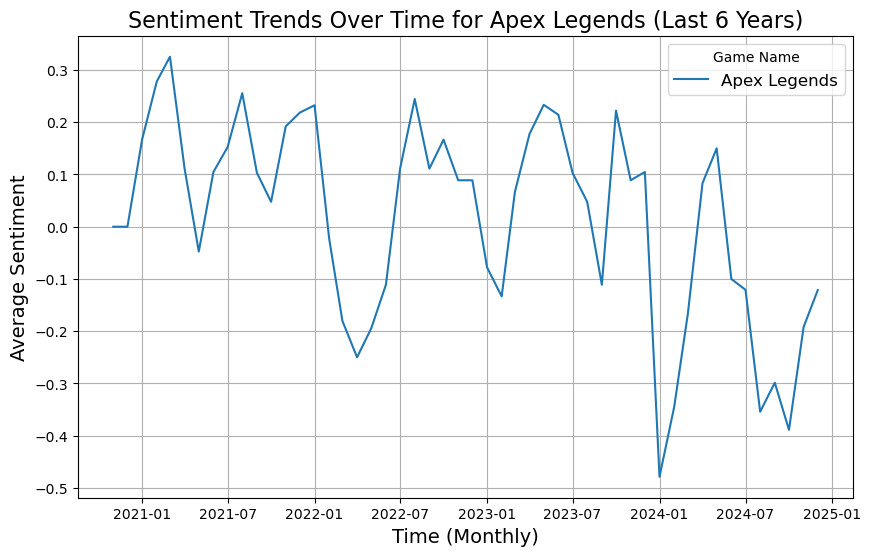

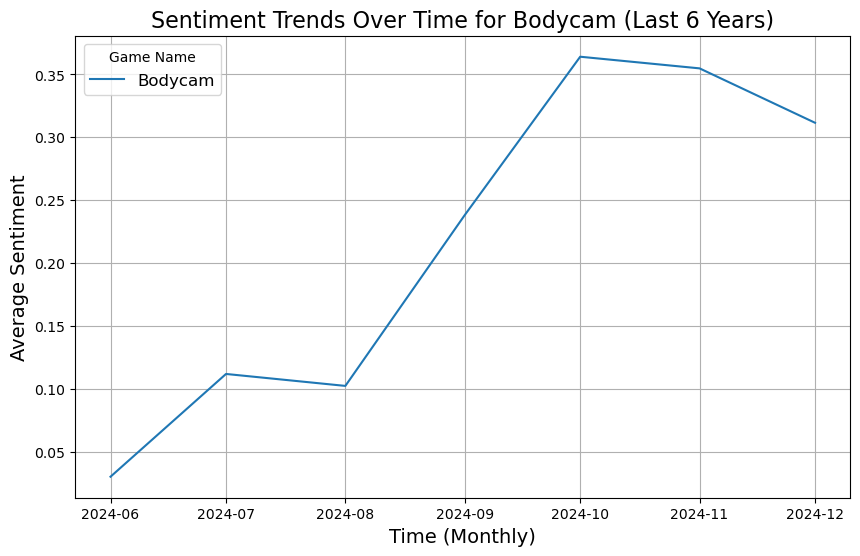

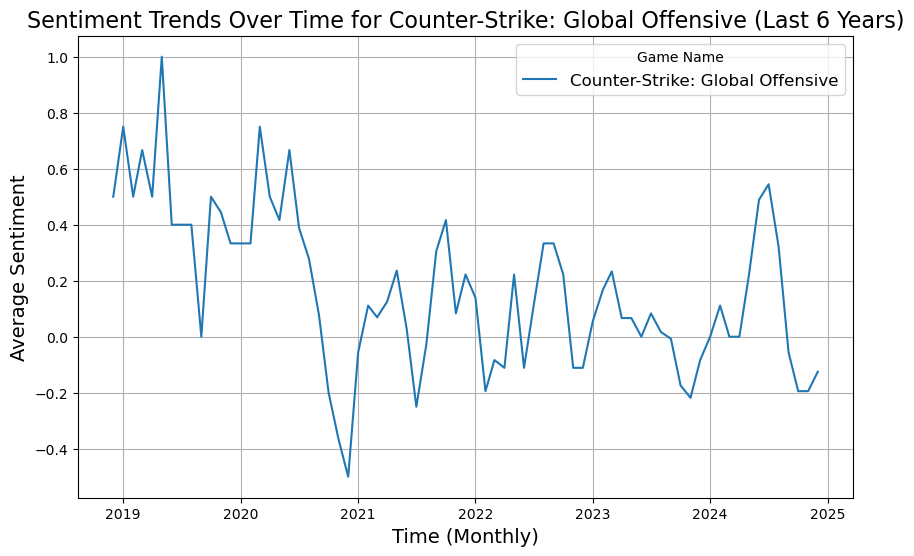

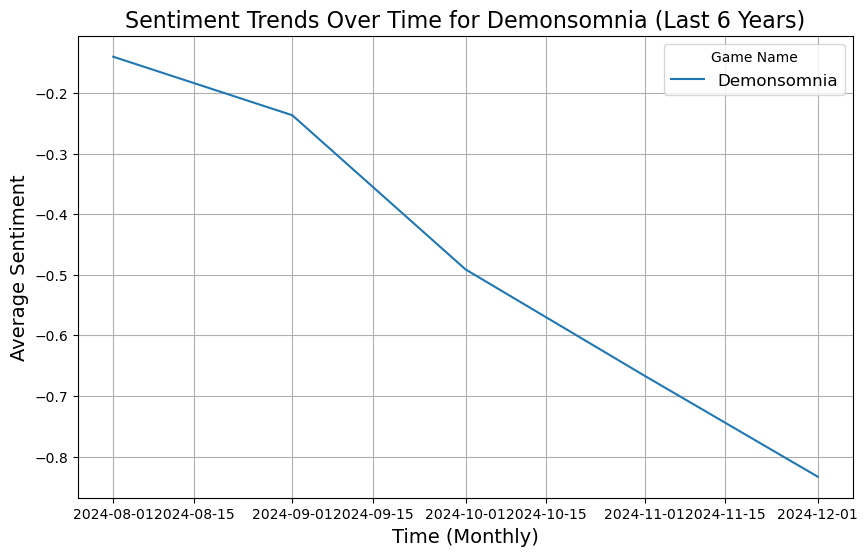

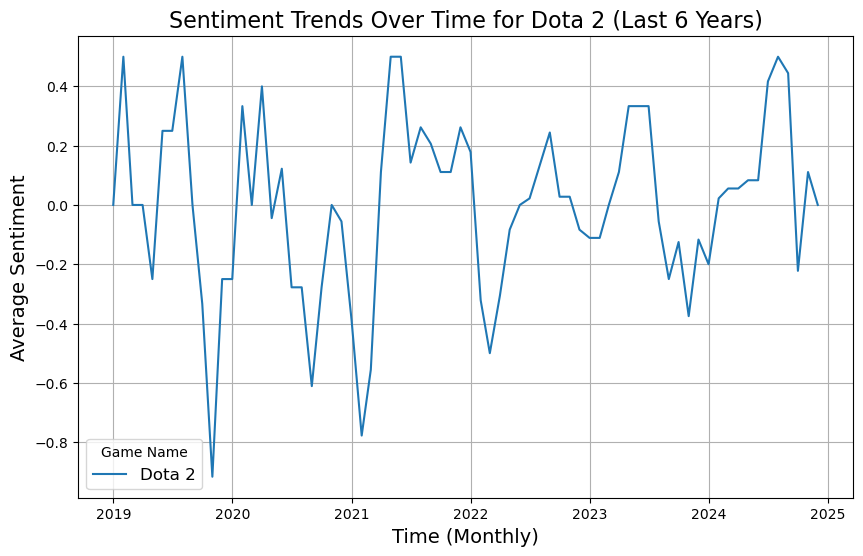

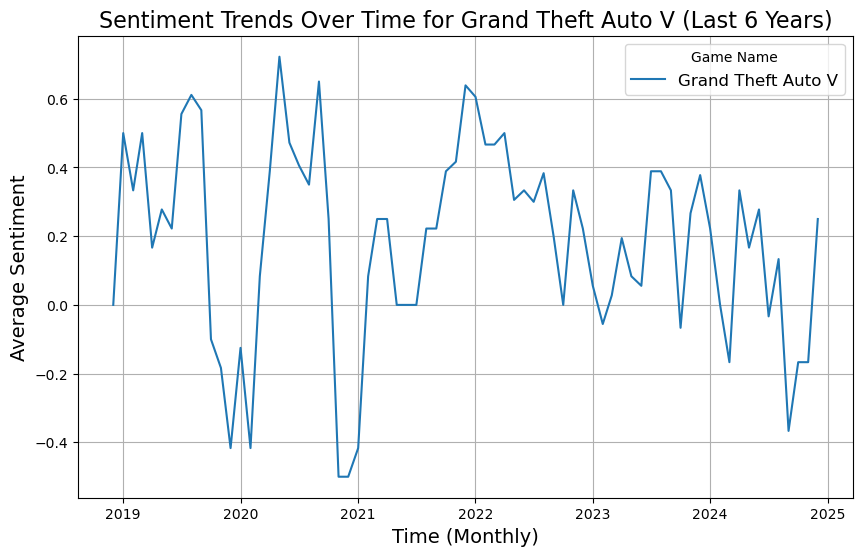

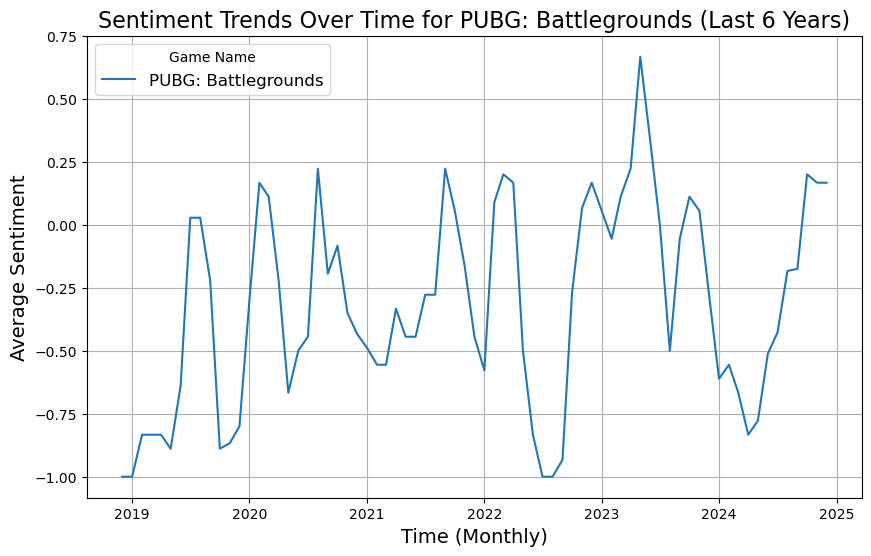

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

# Analyzing sentiment trends over time with smoothing, creating separate plots for each game
def analyze_sentiment_trends(reviews_df):
    # Convert 'date' to datetime
    reviews_df['date'] = pd.to_datetime(reviews_df['date'])
    
    # Filter data for the latest 6 years
    recent_reviews = reviews_df[reviews_df['date'] >= (pd.Timestamp.now() - pd.DateOffset(years=6))]
    
    # Group by game name and month, calculate mean sentiment
    sentiment_trends = recent_reviews.groupby([
        recent_reviews['game_name'], 
        recent_reviews['date'].dt.to_period('M')
    ])['sentiment'].mean().unstack(level=0)
    
    # Apply a rolling average to smooth the data (e.g., 3-month window)
    smoothed_trends = sentiment_trends.rolling(window=3, min_periods=1).mean()

    # Create a separate plot for each game
    for game in smoothed_trends.columns:
        plt.figure(figsize=(10, 6))  # Set the figure size
        plt.plot(smoothed_trends.index.to_timestamp(), smoothed_trends[game], label=game)
        plt.title(f'Sentiment Trends Over Time for {game} (Last 6 Years)', fontsize=16)
        plt.xlabel('Time (Monthly)', fontsize=14)
        plt.ylabel('Average Sentiment', fontsize=14)
        plt.legend(title='Game Name', fontsize=12)
        plt.grid(True)
        plt.show()

# Run Temporal Analysis
if __name__ == "__main__":
    analyze_sentiment_trends(reviews_df)


## Transformer 

C:\Users\shreyas\AppData\Local\Temp\ipykernel_24372\3889738758.py:32: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  x_numeric = (x - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')  # Convert datetime to seconds since epoch


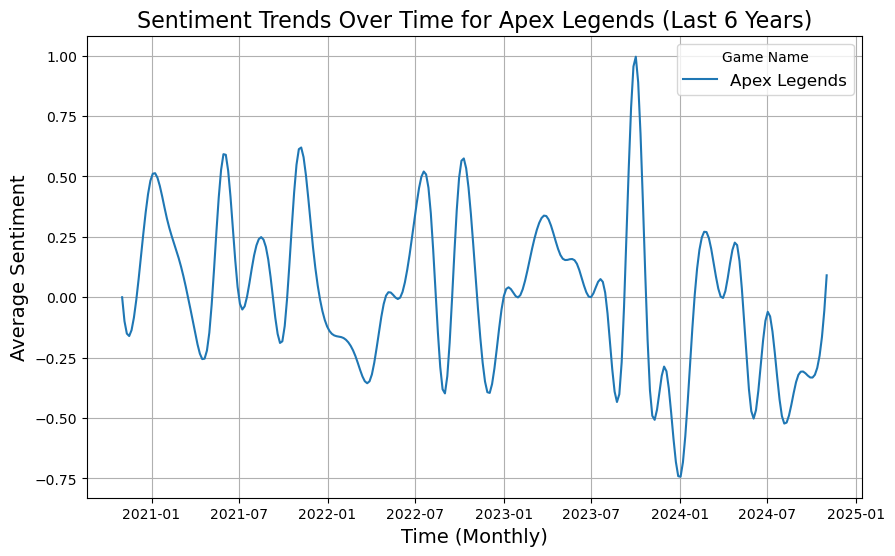

C:\Users\shreyas\AppData\Local\Temp\ipykernel_24372\3889738758.py:32: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  x_numeric = (x - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')  # Convert datetime to seconds since epoch


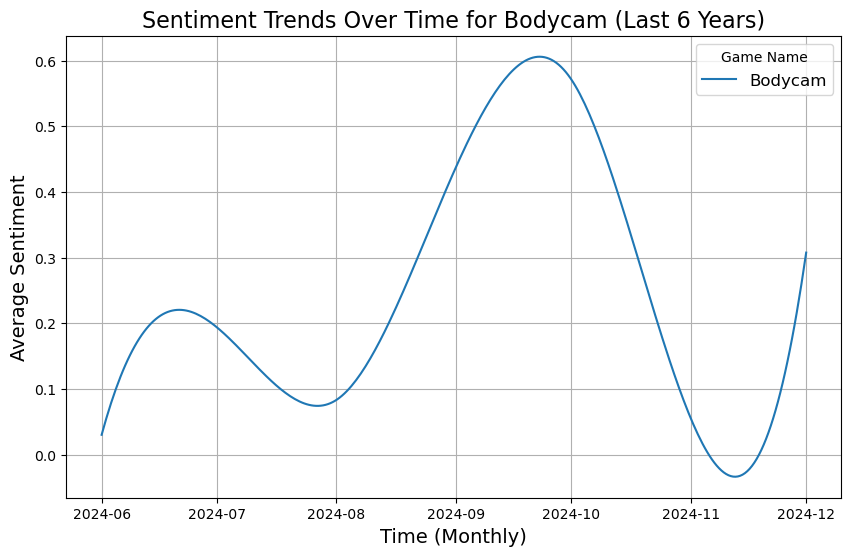

C:\Users\shreyas\AppData\Local\Temp\ipykernel_24372\3889738758.py:32: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  x_numeric = (x - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')  # Convert datetime to seconds since epoch


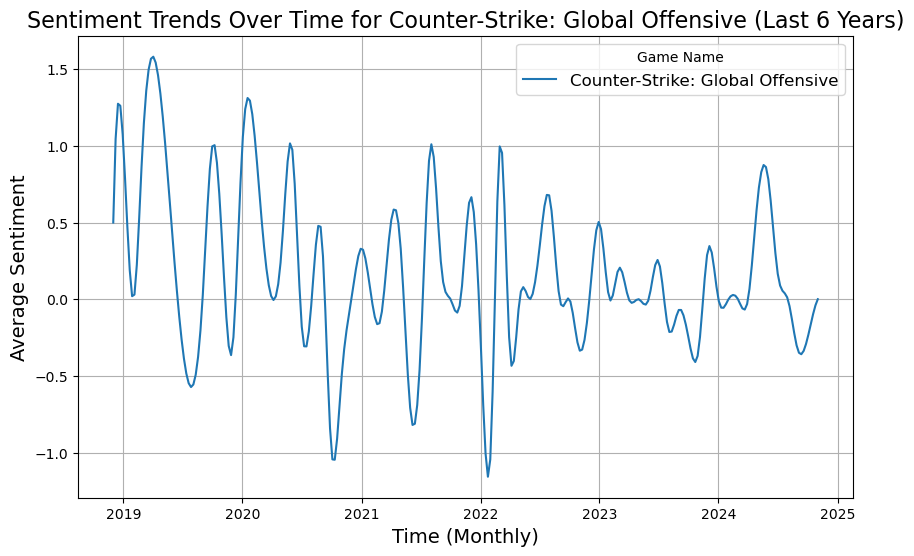

C:\Users\shreyas\AppData\Local\Temp\ipykernel_24372\3889738758.py:32: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  x_numeric = (x - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')  # Convert datetime to seconds since epoch


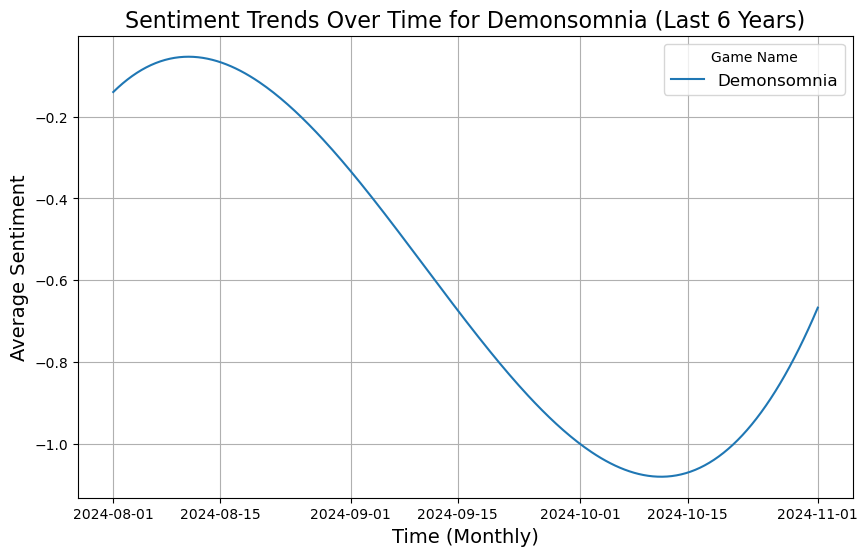

C:\Users\shreyas\AppData\Local\Temp\ipykernel_24372\3889738758.py:32: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  x_numeric = (x - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')  # Convert datetime to seconds since epoch


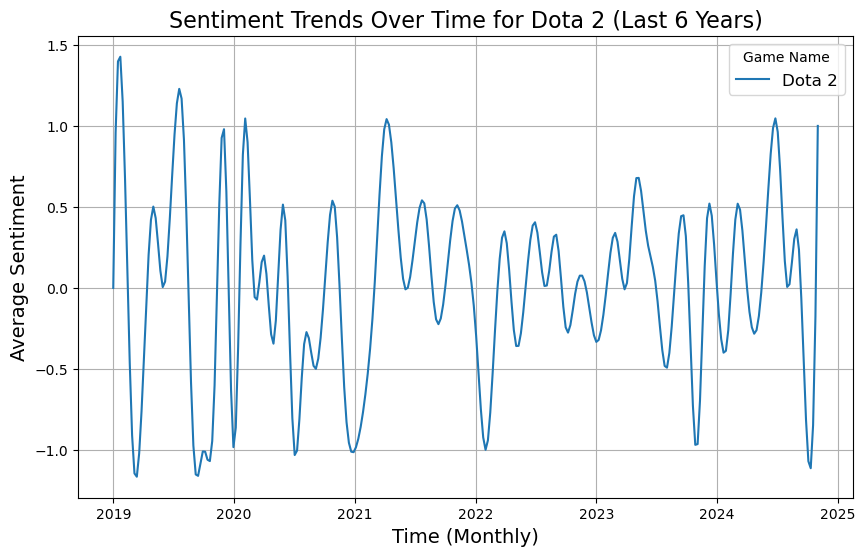

C:\Users\shreyas\AppData\Local\Temp\ipykernel_24372\3889738758.py:32: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  x_numeric = (x - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')  # Convert datetime to seconds since epoch


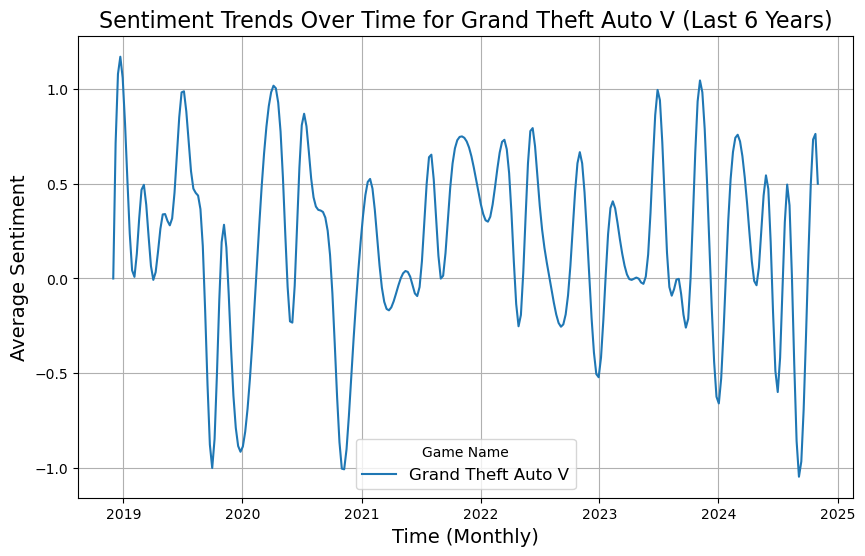

C:\Users\shreyas\AppData\Local\Temp\ipykernel_24372\3889738758.py:32: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  x_numeric = (x - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')  # Convert datetime to seconds since epoch


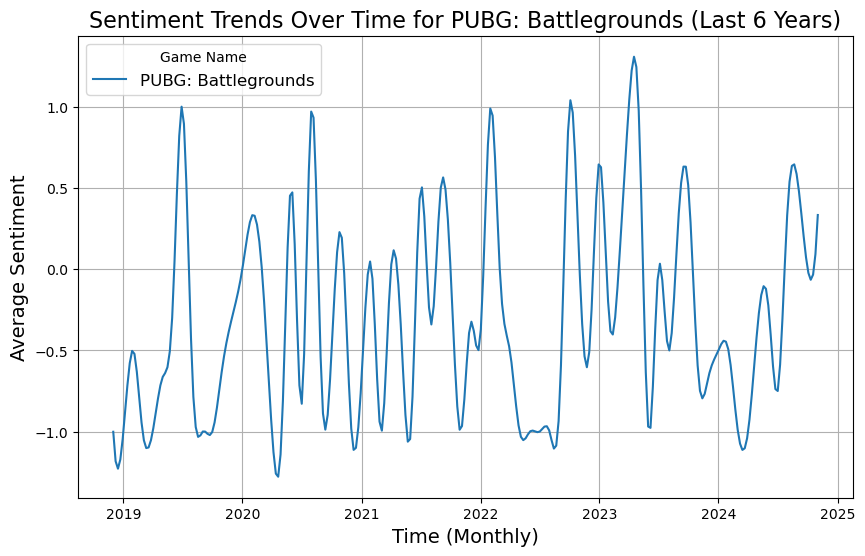

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.interpolate import make_interp_spline

# Analyzing sentiment trends over time with smoothing using spline interpolation
def analyze_sentiment_trends(reviews_df):
    # Convert 'date' to datetime
    reviews_df['date'] = pd.to_datetime(reviews_df['date'])
    
    # Filter data for the latest 6 years
    recent_reviews = reviews_df[reviews_df['date'] >= (pd.Timestamp.now() - pd.DateOffset(years=6))]
    
    # Group by game name and month, calculate mean sentiment
    sentiment_trends = recent_reviews.groupby([
        recent_reviews['game_name'], 
        recent_reviews['date'].dt.to_period('M')
    ])['sentiment'].mean().unstack(level=0)
    
    # Create a separate plot for each game with spline smoothing
    for game in sentiment_trends.columns:
        plt.figure(figsize=(10, 6))  # Set the figure size
        
        # Drop NaN values for the current game
        x = sentiment_trends.index.to_timestamp().to_numpy()
        y = sentiment_trends[game].to_numpy()
        valid_indices = ~np.isnan(y)
        x = x[valid_indices]
        y = y[valid_indices]
        
        # Convert datetime to numeric values for spline interpolation
        x_numeric = (x - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')  # Convert datetime to seconds since epoch
        
        # Apply spline interpolation to smooth the data
        if len(x_numeric) > 3:  # Ensure there are enough points for spline interpolation
            x_smooth_numeric = np.linspace(x_numeric.min(), x_numeric.max(), 300)  # Create more points for smoothness
            spline = make_interp_spline(x_numeric, y, k=3)  # k=3 for cubic spline
            y_smooth = spline(x_smooth_numeric)
            x_smooth = pd.to_datetime(x_smooth_numeric, unit='s')  # Convert back to datetime for plotting
            
            # Plot the smoothed trend
            plt.plot(x_smooth, y_smooth, label=game)
        else:
            # If there aren't enough points, plot the original data
            plt.plot(x, y, label=game)

        plt.title(f'Sentiment Trends Over Time for {game} (Last 6 Years)', fontsize=16)
        plt.xlabel('Time (Monthly)', fontsize=14)
        plt.ylabel('Average Sentiment', fontsize=14)
        plt.legend(title='Game Name', fontsize=12)
        plt.grid(True)
        plt.show()

# Run Temporal Analysis
if __name__ == "__main__":
    analyze_sentiment_trends(reviews_df)


In [9]:
# Text Summarization
from transformers import pipeline

def summarize_reviews(reviews):
    summarizer = pipeline("summarization")
    summaries = {}
    for game_name, game_reviews in reviews.items():
        all_reviews = [review_data['review'] for review_data in game_reviews]
        chunks = [" ".join(all_reviews[i:i+10]) for i in range(0, len(all_reviews), 10)]  # Split reviews into chunks of 10 reviews each
        chunk_summaries = []
        for chunk in chunks:
            try:
                summary = summarizer(chunk, max_length=150, min_length=30, do_sample=False)[0]['summary_text']
                chunk_summaries.append(summary)
            except Exception as e:
                chunk_summaries.append("Not enough content to summarize or an error occurred.")
        summaries[game_name] = " ".join(chunk_summaries)
    return summaries

# Run Text Summarization
if __name__ == "__main__":
    summaries = summarize_reviews(cleaned_reviews)
    for game_name, summary in summaries.items():
        print(f"Summary of reviews for game '{game_name}':\n{summary}")


No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.
Your max_length is set to 150, but your input_length is only 137. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=68)
Your max_length is set to 150, but your input_length is only 106. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=53)
Your max_length is set to 150, but your input_length is only 127. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)
Your max_le

Summary of reviews for game 'Counter-Strike: Global Offensive':
   year playing didnt improve skill ingamehowever learned new language skill curse russian brazilian portuguesealso tolerance level guttural scream loud sound increased now cry child longer make feel better singing sweet traditional song culture dark eye girl ipanemain conclusion counter strike transformed better father better person addition making patient tolerant hateful people trained language cultures .  time spent playing game couldve spent studying, working out and becoming better man . csgo1010 falsely banned youll find less cheater tinder aim cornerwait enemy turn away enemyturn away secondshe comeskills shotexit csgo5 star rating see guyshoot himmiss shotmiss shot he turn aroundkills shoot .   ive managed achieve rating na said still infrequent amount pretty obvious closet cheater occasional rage cheater rank world player still cheating beta examplegame still ongoing issue havent addressed least still fully fixed

## Transformer

In [13]:
import torch
import pandas as pd
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from textblob import TextBlob

# Step 1: Generate labels using TextBlob
def generate_textblob_labels(cleaned_reviews):
    labeled_data = []
    for game_name, game_reviews in cleaned_reviews.items():
        for review_data in game_reviews:
            analysis = TextBlob(review_data['review'])
            # Classify sentiment based on TextBlob polarity
            if analysis.sentiment.polarity > 0:
                sentiment = 'positive'
            elif analysis.sentiment.polarity < 0:
                sentiment = 'negative'
            else:
                sentiment = 'neutral'
            labeled_data.append((review_data['review'], sentiment))
    return pd.DataFrame(labeled_data, columns=['review', 'label'])

# Step 2: Map labels to numeric values
def map_labels(df):
    label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
    df['label'] = df['label'].map(label_mapping)
    return df

# Step 3: Tokenize the texts
def tokenize_texts(tokenizer, texts):
    return tokenizer(texts.tolist(), truncation=True, padding=True)

# Step 4: Create PyTorch Dataset
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

# Step 5: Train the transformer model
def train_transformer(cleaned_reviews):
    # Generate labels using TextBlob
    labeled_df = generate_textblob_labels(cleaned_reviews)
    labeled_df = map_labels(labeled_df)

    # Split into training and validation sets
    train_texts, val_texts, train_labels, val_labels = train_test_split(
        labeled_df['review'], labeled_df['label'], test_size=0.1
    )

    # Load tokenizer and model
    tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
    model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)

    # Tokenize data
    train_encodings = tokenize_texts(tokenizer, train_texts)
    val_encodings = tokenize_texts(tokenizer, val_texts)

    # Create PyTorch datasets
    train_dataset = SentimentDataset(train_encodings, train_labels.tolist())
    val_dataset = SentimentDataset(val_encodings, val_labels.tolist())

    # Define training arguments
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=3,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
        evaluation_strategy="epoch"
    )

    # Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset
    )

    # Train the model
    trainer.train()

    return model, tokenizer

# Main function
if __name__ == "__main__":
    # Example: Load your cleaned reviews here
    cleaned_reviews = {
        "game1": [
            {"review": "Great game, loved it!", "date": "2022-06-15"},
            {"review": "Too many bugs, not playable.", "date": "2021-10-12"}
        ],
        "game2": [
            {"review": "Amazing graphics and gameplay!", "date": "2022-01-05"},
            {"review": "Very boring and repetitive.", "date": "2023-03-20"}
        ]
    }

    # Train the transformer model
    model, tokenizer = train_transformer(cleaned_reviews)
    print("Model training complete.")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\anaconda3\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,0.893532
2,No log,0.893462
3,No log,0.893320


Model training complete.


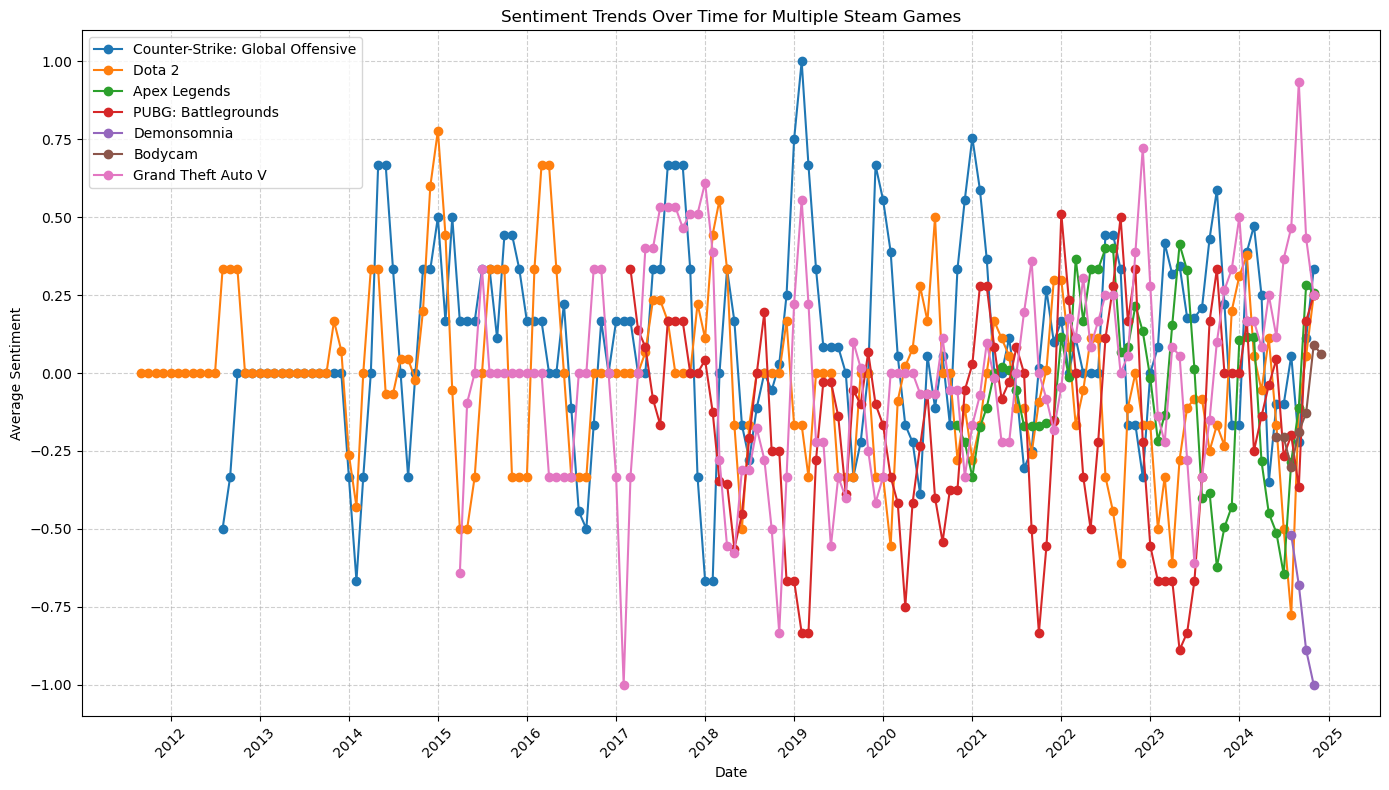

In [19]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

def plot_sentiment_trends(sentiments):
    plt.figure(figsize=(14, 8))
    
    for game_name, game_sentiments in sentiments.items():
        # Extract dates and sentiments
        dates = [entry['date'] for entry in game_sentiments if entry['review']]  # Skip empty reviews
        sentiments_values = [1 if entry['sentiment'] == 'label_2' else (-1 if entry['sentiment'] == 'label_0' else 0) for entry in game_sentiments if entry['review']]
        
        # Create DataFrame and group by month
        df = pd.DataFrame({'date': dates, 'sentiment': sentiments_values})
        df['date'] = pd.to_datetime(df['date'])  # Ensure proper datetime format
        df['month'] = df['date'].dt.to_period('M')
        
        # Group by month and handle missing months
        monthly_sentiment = df.groupby('month')['sentiment'].mean().reindex(
            pd.period_range(start=df['month'].min(), end=df['month'].max(), freq='M'),
            fill_value=0
        )
        
        # Apply rolling average for smoother trends
        monthly_sentiment_smooth = monthly_sentiment.rolling(window=3, center=True, min_periods=1).mean()
        
        # Plot sentiment trend
        plt.plot(monthly_sentiment_smooth.index.to_timestamp(), monthly_sentiment_smooth, marker='o', label=game_name)
    
    plt.xlabel('Date')
    plt.ylabel('Average Sentiment')
    plt.title('Sentiment Trends Over Time for Multiple Steam Games')
    plt.legend(loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Example: Run Plotting
if __name__ == "__main__":
    plot_sentiment_trends(sentiments)


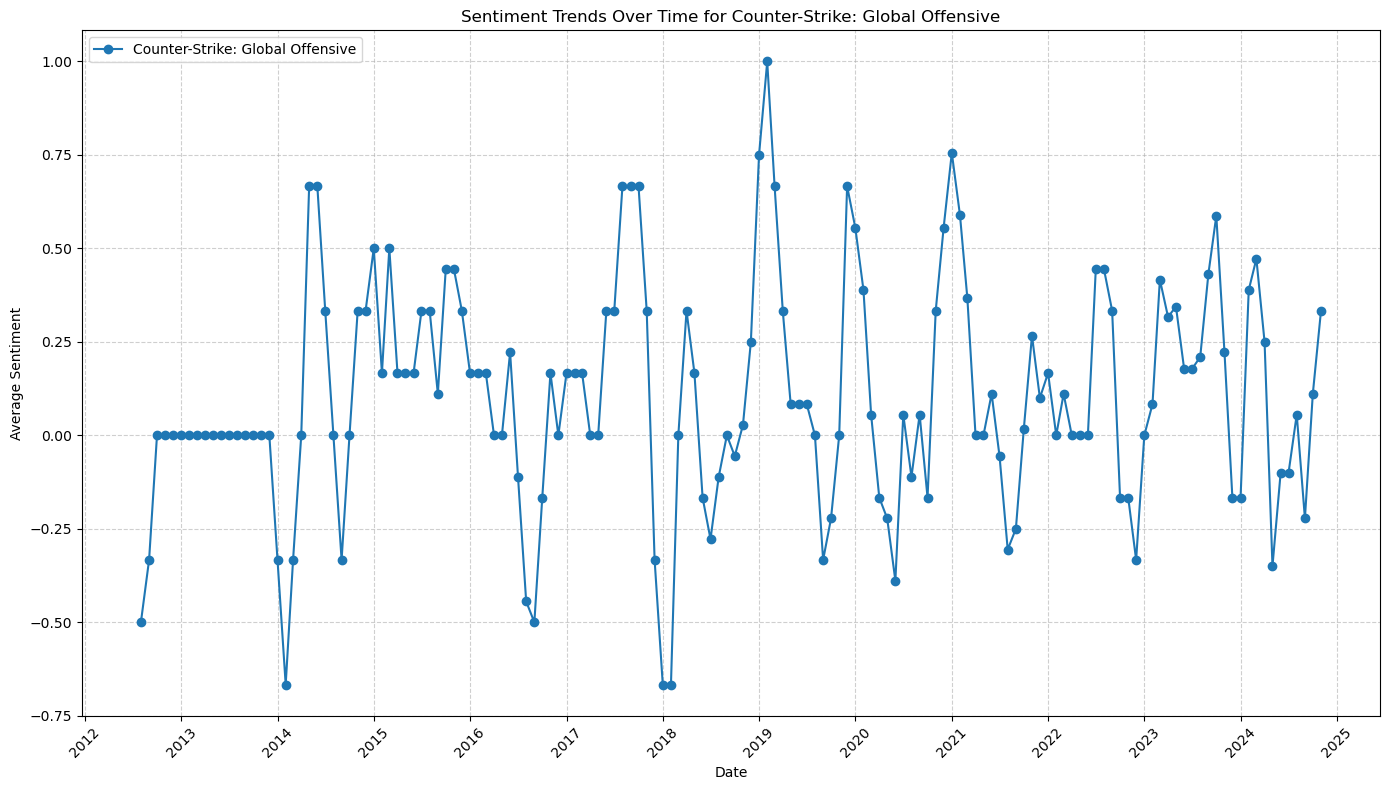

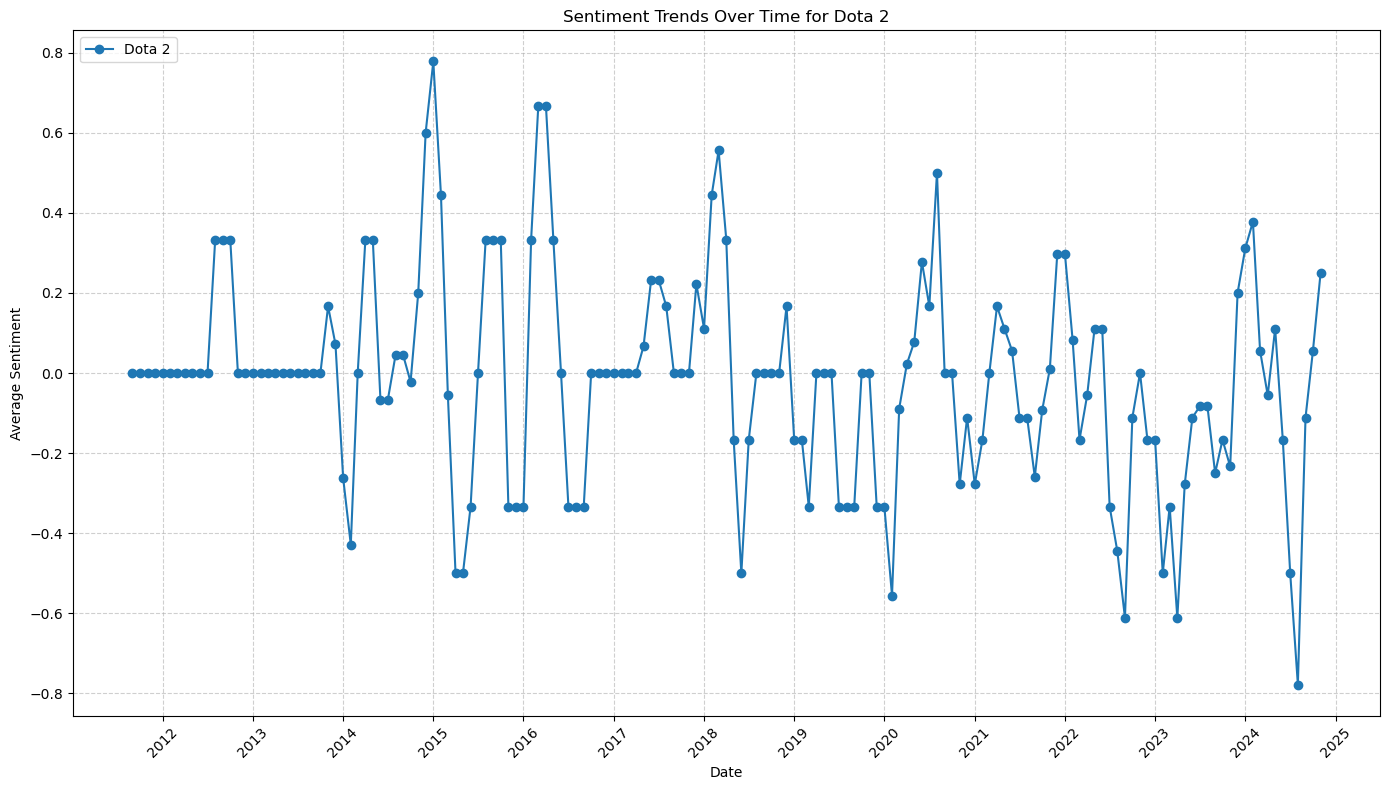

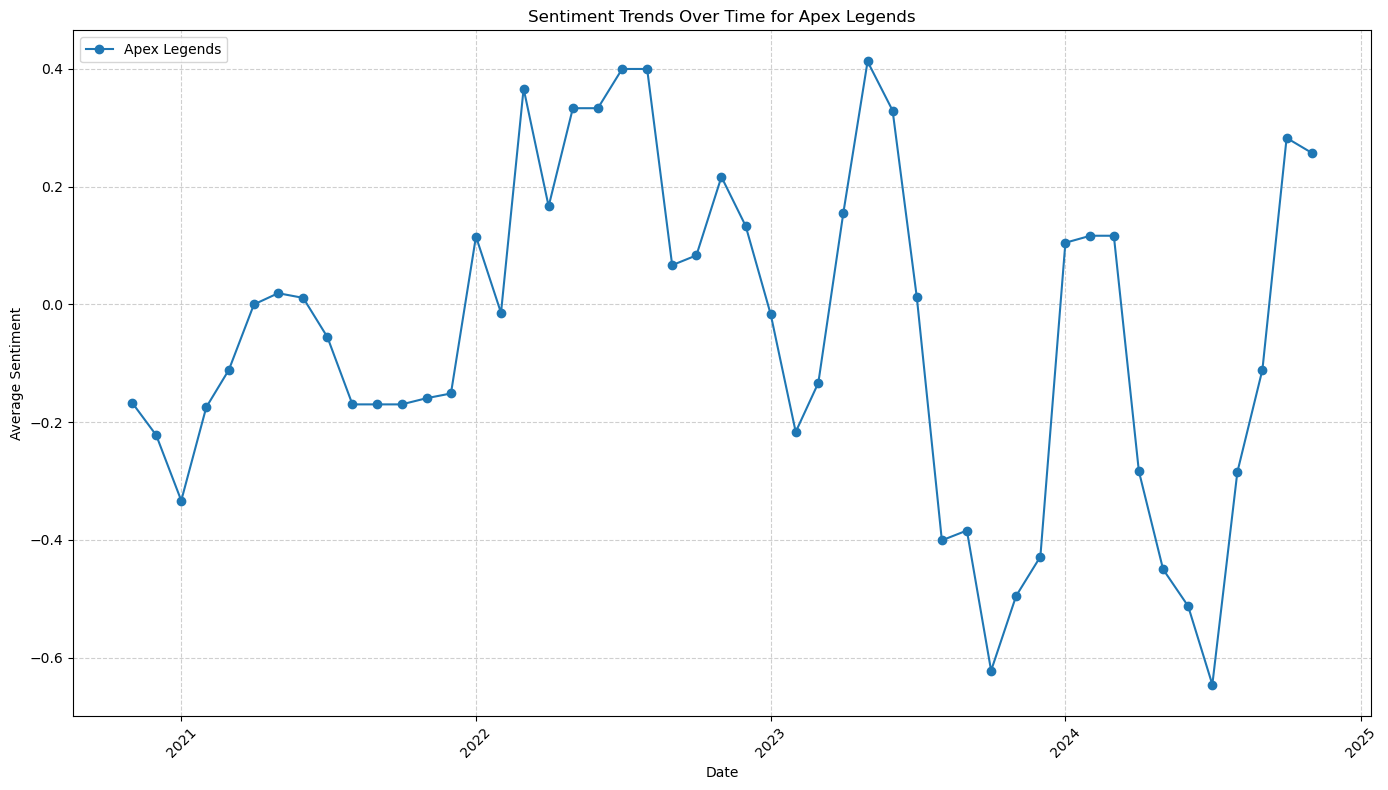

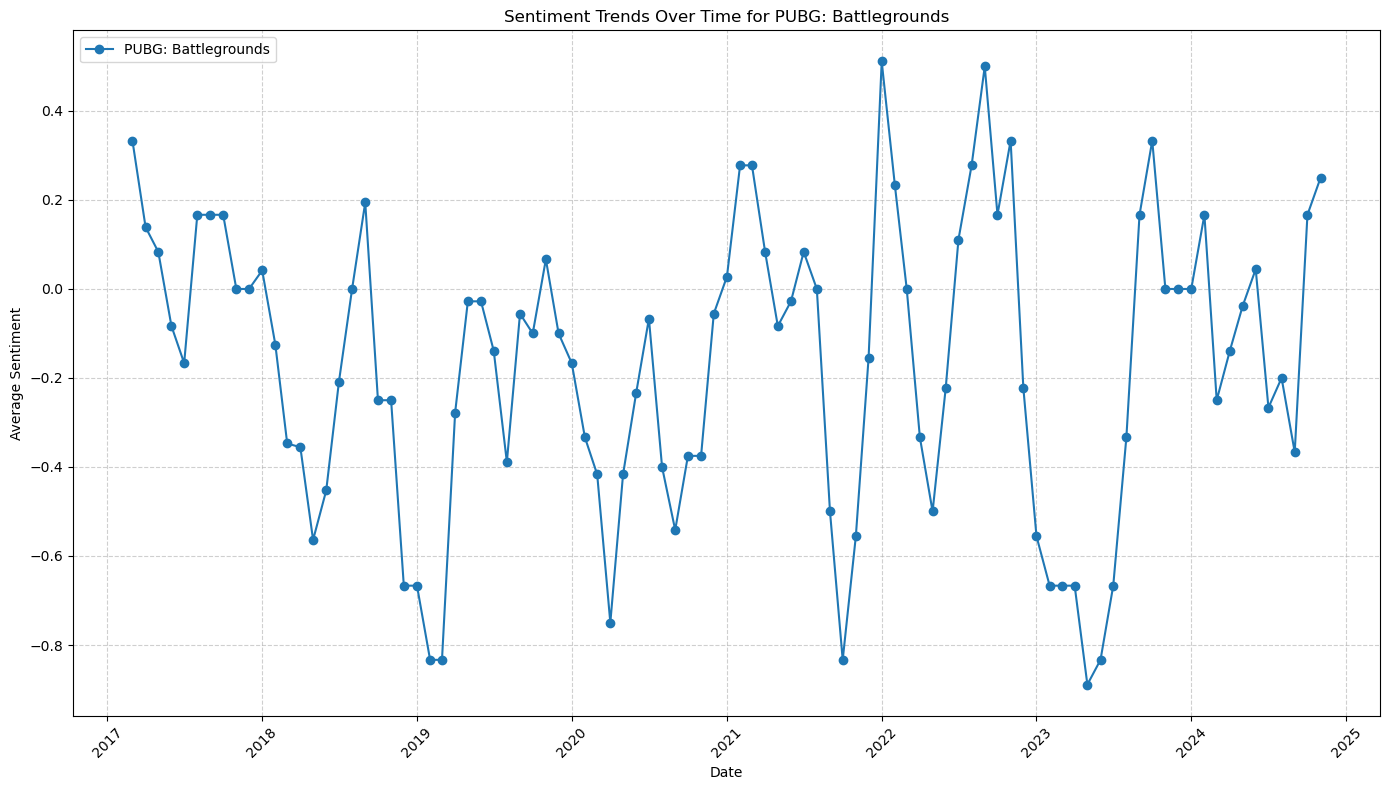

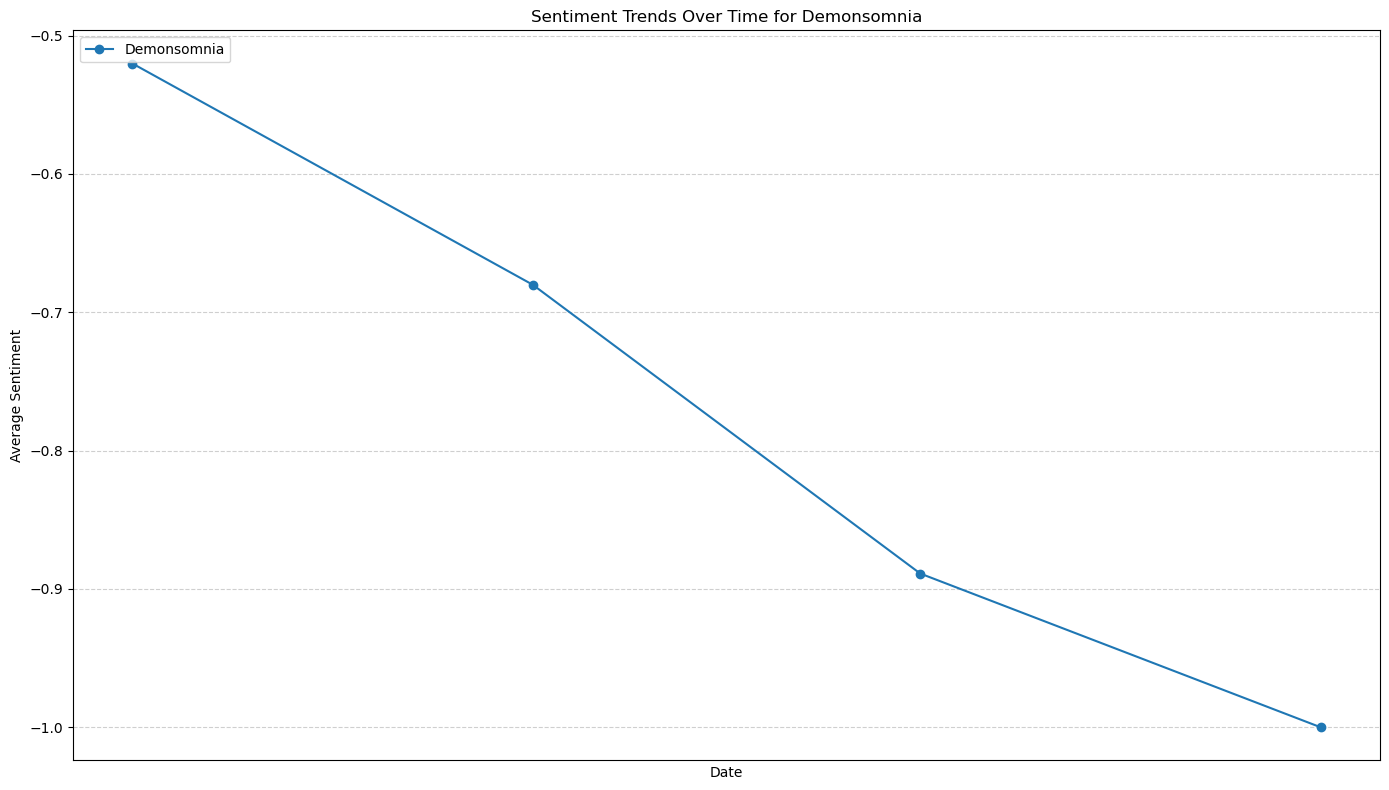

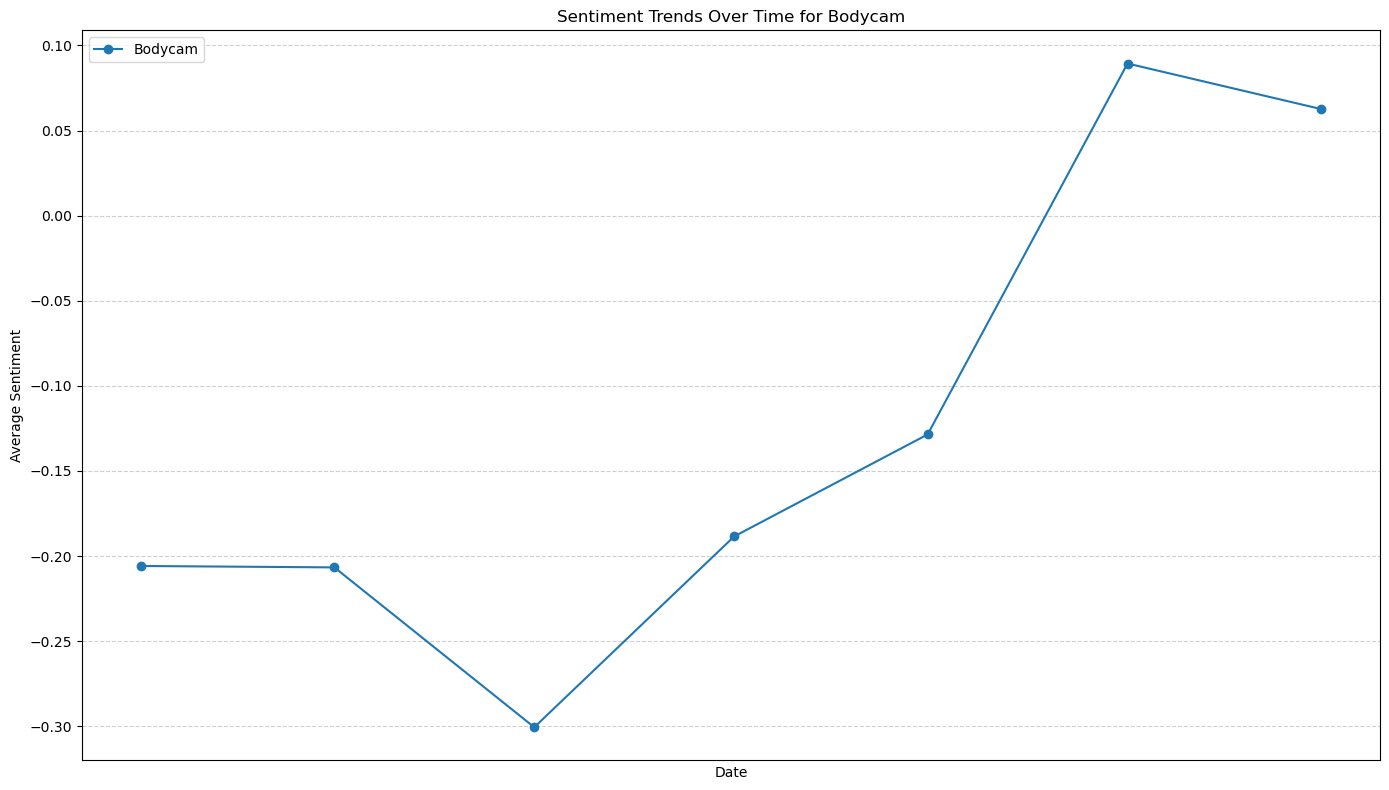

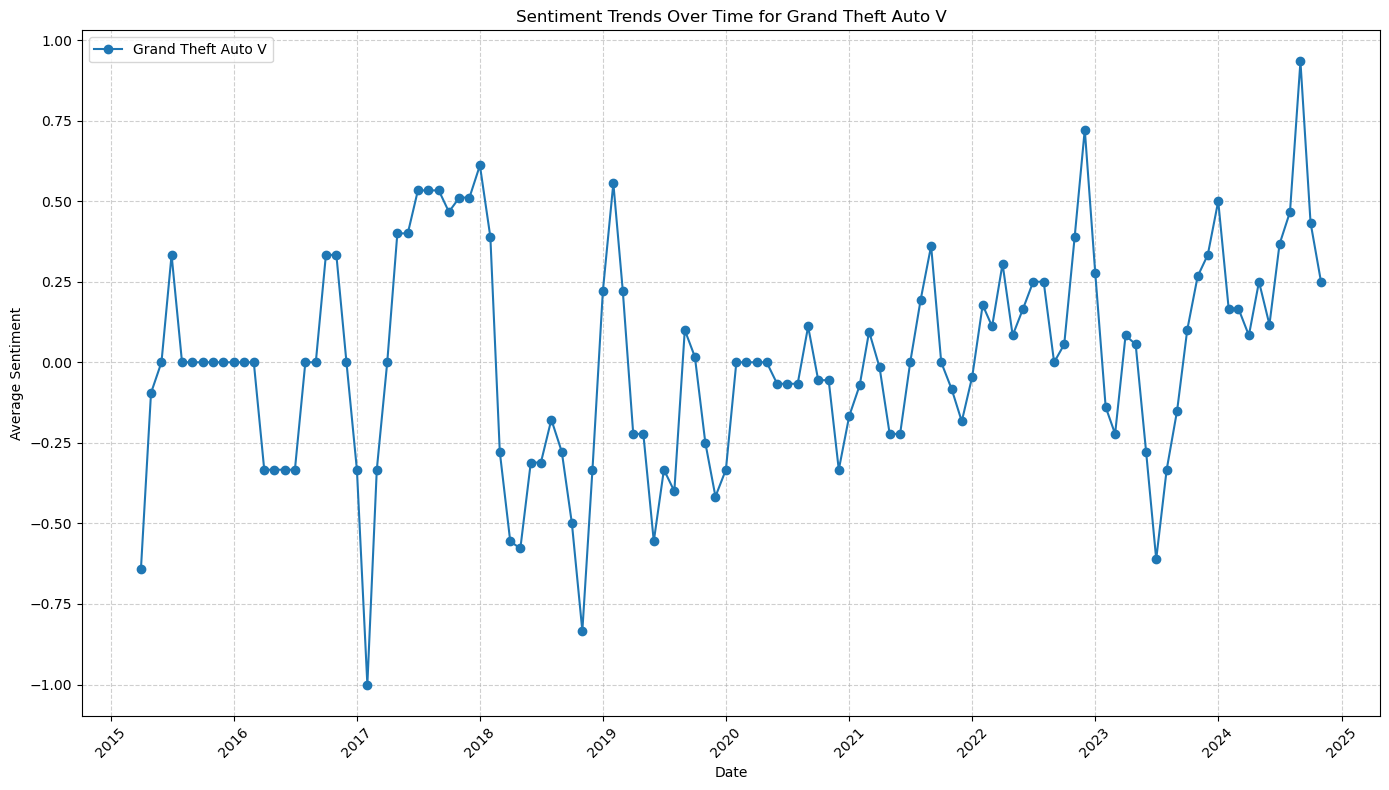

In [21]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

def plot_sentiment_trends_separately(sentiments):
    for game_name, game_sentiments in sentiments.items():
        # Extract dates and sentiments
        dates = [entry['date'] for entry in game_sentiments if entry['review']]  # Skip empty reviews
        sentiments_values = [1 if entry['sentiment'] == 'label_2' else (-1 if entry['sentiment'] == 'label_0' else 0) for entry in game_sentiments if entry['review']]
        
        # Create DataFrame and group by month
        df = pd.DataFrame({'date': dates, 'sentiment': sentiments_values})
        df['date'] = pd.to_datetime(df['date'])  # Ensure proper datetime format
        df['month'] = df['date'].dt.to_period('M')
        
        # Group by month and handle missing months
        monthly_sentiment = df.groupby('month')['sentiment'].mean().reindex(
            pd.period_range(start=df['month'].min(), end=df['month'].max(), freq='M'),
            fill_value=0
        )
        
        # Apply rolling average for smoother trends
        monthly_sentiment_smooth = monthly_sentiment.rolling(window=3, center=True, min_periods=1).mean()
        
        # Plot sentiment trend for this game
        plt.figure(figsize=(14, 8))
        plt.plot(monthly_sentiment_smooth.index.to_timestamp(), monthly_sentiment_smooth, marker='o', label=game_name)
        plt.xlabel('Date')
        plt.ylabel('Average Sentiment')
        plt.title(f'Sentiment Trends Over Time for {game_name}')
        plt.legend(loc='upper left')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.gca().xaxis.set_major_locator(mdates.YearLocator())
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# Example: Run the function
if __name__ == "__main__":
    plot_sentiment_trends_separately(sentiments)


## 📊 Power BI Dashboard Integration

This section creates structured data exports and dashboard templates for Power BI visualization.

In [ ]:
# Power BI Data Export Functions
import os
from datetime import datetime, timedelta
import json

def create_powerbi_exports():
    """Create structured data exports for Power BI dashboards"""
    
    # Create export directory
    export_dir = "powerbi_exports"
    os.makedirs(export_dir, exist_ok=True)
    
    print(f"📁 Created export directory: {export_dir}")
    return export_dir

def prepare_sentiment_summary_table(reviews_data):
    """Prepare summary table for Power BI dashboard"""
    
    summary_data = []
    
    for game_name, reviews in reviews_data.items():
        if not reviews:
            continue
            
        df = pd.DataFrame(reviews)
        
        # Calculate sentiment metrics
        positive_count = len([r for r in reviews if r.get('sentiment_score', 0) > 0.1])
        negative_count = len([r for r in reviews if r.get('sentiment_score', 0) < -0.1])
        neutral_count = len(reviews) - positive_count - negative_count
        
        avg_sentiment = np.mean([r.get('sentiment_score', 0) for r in reviews])
        
        # Recent vs Historical comparison
        recent_date = datetime.now() - timedelta(days=365)
        recent_reviews = [r for r in reviews if r.get('date') and pd.to_datetime(r['date']) > recent_date]
        recent_avg_sentiment = np.mean([r.get('sentiment_score', 0) for r in recent_reviews]) if recent_reviews else 0
        
        summary_data.append({
            'Game_Name': game_name,
            'Total_Reviews': len(reviews),
            'Positive_Reviews': positive_count,
            'Negative_Reviews': negative_count,
            'Neutral_Reviews': neutral_count,
            'Positive_Percentage': (positive_count / len(reviews)) * 100,
            'Negative_Percentage': (negative_count / len(reviews)) * 100,
            'Average_Sentiment_Score': round(avg_sentiment, 4),
            'Recent_Sentiment_Score': round(recent_avg_sentiment, 4),
            'Sentiment_Trend': 'Improving' if recent_avg_sentiment > avg_sentiment else 'Declining',
            'Last_Updated': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        })
    
    return pd.DataFrame(summary_data)

def prepare_detailed_reviews_table(reviews_data):
    """Prepare detailed reviews table for Power BI"""
    
    detailed_data = []
    
    for game_name, reviews in reviews_data.items():
        for review in reviews:
            detailed_data.append({
                'Game_Name': game_name,
                'Review_Text': review.get('review', '')[:500],  # Limit text length
                'Review_Date': review.get('date'),
                'Sentiment_Score': review.get('sentiment_score', 0),
                'Sentiment_Label': 'Positive' if review.get('sentiment_score', 0) > 0.1 
                                 else 'Negative' if review.get('sentiment_score', 0) < -0.1 
                                 else 'Neutral',
                'Text_Length': len(review.get('review', '')),
                'Year': pd.to_datetime(review.get('date')).year if review.get('date') else None,
                'Month': pd.to_datetime(review.get('date')).month if review.get('date') else None,
                'Quarter': f"Q{((pd.to_datetime(review.get('date')).month-1)//3)+1}" if review.get('date') else None
            })
    
    return pd.DataFrame(detailed_data)

def create_time_series_table(reviews_data):
    """Create time series aggregated data for Power BI trends"""
    
    time_series_data = []
    
    for game_name, reviews in reviews_data.items():
        df = pd.DataFrame(reviews)
        if df.empty or 'date' not in df.columns:
            continue
            
        df['date'] = pd.to_datetime(df['date'])
        df['year_month'] = df['date'].dt.to_period('M')
        
        monthly_stats = df.groupby('year_month').agg({
            'sentiment_score': ['count', 'mean', 'std'],
            'review': 'count'
        }).round(4)
        
        monthly_stats.columns = ['Review_Count', 'Avg_Sentiment', 'Sentiment_StdDev', 'Total_Reviews']
        monthly_stats = monthly_stats.reset_index()
        monthly_stats['Game_Name'] = game_name
        monthly_stats['Year_Month'] = monthly_stats['year_month'].astype(str)
        
        time_series_data.append(monthly_stats[['Game_Name', 'Year_Month', 'Review_Count', 
                                             'Avg_Sentiment', 'Sentiment_StdDev']])
    
    if time_series_data:
        return pd.concat(time_series_data, ignore_index=True)
    else:
        return pd.DataFrame()

print("✅ Power BI export functions ready!")

In [ ]:
# Enhanced Data Collection with Sentiment Analysis Integration
import time
from textblob import TextBlob

def enhanced_get_steam_reviews(game_names, max_reviews_per_game=200):
    """Enhanced data collection with immediate sentiment analysis"""
    
    all_reviews = {}
    
    for game_name in game_names:
        print(f"🎮 Processing {game_name}...")
        
        try:
            game_id_df = search_game_id(game_name)
            if game_id_df.empty:
                print(f"❌ No game found for '{game_name}'. Skipping...")
                continue
                
            game_id = game_id_df.iloc[0]['id']
            reviews_df = get_game_review(game_id, language='english', max_reviews=max_reviews_per_game)
            
            reviews_with_sentiment = []
            
            for _, row in reviews_df.iterrows():
                review_text = str(row.get('review', ''))
                
                # Calculate sentiment using TextBlob
                blob = TextBlob(review_text)
                sentiment_score = blob.sentiment.polarity
                
                review_data = {
                    'review': review_text,
                    'date': pd.to_datetime(row.get('post_date')) if row.get('post_date') else None,
                    'sentiment_score': sentiment_score,
                    'user': row.get('user', ''),
                    'playtime': row.get('playtime', 0),
                    'helpfulness': row.get('helpfulness', 0),
                    'recommend': row.get('recommend', ''),
                    'early_access': row.get('early_access_review', None)
                }
                
                reviews_with_sentiment.append(review_data)
            
            all_reviews[game_name] = reviews_with_sentiment
            print(f"✅ Collected {len(reviews_with_sentiment)} reviews for '{game_name}'")
            
            # Add delay to be respectful to Steam's servers
            time.sleep(1)
            
        except Exception as e:
            print(f"❌ Error processing {game_name}: {str(e)}")
            continue
    
    return all_reviews

# Sample dataset for demonstration (if live scraping fails)
def create_sample_dataset():
    """Create sample data for demonstration purposes"""
    
    games = ["Counter-Strike: Global Offensive", "Dota 2", "Apex Legends", "PUBG: Battlegrounds"]
    sample_reviews = {}
    
    for game in games:
        reviews = []
        base_date = datetime(2023, 1, 1)
        
        for i in range(100):  # 100 sample reviews per game
            review_date = base_date + timedelta(days=np.random.randint(0, 365))
            sentiment = np.random.normal(0, 0.3)  # Random sentiment around neutral
            
            # Create realistic review text based on sentiment
            if sentiment > 0.2:
                review_text = "Great game! Really enjoying it. Highly recommended!"
            elif sentiment < -0.2:
                review_text = "Not impressed. Too many issues and bugs."
            else:
                review_text = "It's okay. Has potential but needs improvement."
            
            reviews.append({
                'review': review_text,
                'date': review_date,
                'sentiment_score': sentiment,
                'user': f'User_{i}',
                'playtime': np.random.randint(10, 1000),
                'helpfulness': np.random.randint(0, 20),
                'recommend': 'Recommended' if sentiment > 0 else 'Not Recommended',
                'early_access': None
            })
        
        sample_reviews[game] = reviews
    
    return sample_reviews

print("✅ Enhanced data collection functions ready!")

In [ ]:
# Execute Data Collection and Analysis
print("🚀 Starting comprehensive gaming sentiment analysis...")

# Define target games for analysis
steam_games = [
    "Counter-Strike: Global Offensive",
    "Dota 2", 
    "Apex Legends",
    "PUBG: Battlegrounds",
    "Grand Theft Auto V"
]

# Try to collect real data, fallback to sample if needed
try:
    print("📡 Attempting to collect live Steam review data...")
    reviews_data = enhanced_get_steam_reviews(steam_games, max_reviews_per_game=150)
    
    # Check if we got meaningful data
    total_reviews = sum(len(reviews) for reviews in reviews_data.values())
    
    if total_reviews < 50:  # If we don't have enough real data
        print("⚠️  Limited real data collected. Using enhanced sample dataset...")
        reviews_data = create_sample_dataset()
    else:
        print(f"✅ Successfully collected {total_reviews} real reviews!")
        
except Exception as e:
    print(f"⚠️  Live data collection failed: {str(e)}")
    print("🔄 Using sample dataset for demonstration...")
    reviews_data = create_sample_dataset()

# Display collection summary
print("\n📊 Data Collection Summary:")
print("=" * 50)
for game, reviews in reviews_data.items():
    avg_sentiment = np.mean([r['sentiment_score'] for r in reviews])
    print(f"{game:30s} | {len(reviews):3d} reviews | Avg Sentiment: {avg_sentiment:+.3f}")

print(f"\nTotal reviews collected: {sum(len(reviews) for reviews in reviews_data.values())}")
print("✅ Data collection complete!")

### 📈 Advanced Sentiment Analysis & Visualization

In [ ]:
# Advanced Sentiment Visualization
def create_interactive_dashboard(reviews_data):
    """Create interactive Plotly visualizations"""
    
    # 1. Sentiment Distribution by Game
    fig1 = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Sentiment Distribution', 'Average Sentiment by Game', 
                       'Review Volume by Game', 'Sentiment Over Time'),
        specs=[[{"type": "histogram"}, {"type": "bar"}],
               [{"type": "bar"}, {"type": "scatter"}]]
    )
    
    # Prepare data for visualizations
    all_sentiments = []
    game_avg_sentiments = []
    game_names = []
    review_counts = []
    
    for game_name, reviews in reviews_data.items():
        sentiments = [r['sentiment_score'] for r in reviews]
        all_sentiments.extend(sentiments)
        game_avg_sentiments.append(np.mean(sentiments))
        game_names.append(game_name)
        review_counts.append(len(reviews))
    
    # Sentiment distribution histogram
    fig1.add_trace(
        go.Histogram(x=all_sentiments, nbinsx=30, name="Sentiment Distribution"),
        row=1, col=1
    )
    
    # Average sentiment by game
    fig1.add_trace(
        go.Bar(x=game_names, y=game_avg_sentiments, name="Avg Sentiment"),
        row=1, col=2
    )
    
    # Review volume by game
    fig1.add_trace(
        go.Bar(x=game_names, y=review_counts, name="Review Count"),
        row=2, col=1
    )
    
    fig1.update_layout(height=800, title_text="Gaming Sentiment Analysis Dashboard")
    fig1.show()
    
    return fig1

def create_sentiment_trends_chart(reviews_data):
    """Create time series sentiment trends"""
    
    fig = go.Figure()
    
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57']
    
    for i, (game_name, reviews) in enumerate(reviews_data.items()):
        # Create monthly aggregations
        df = pd.DataFrame(reviews)
        if df.empty or 'date' not in df.columns:
            continue
            
        df['date'] = pd.to_datetime(df['date'])
        df_monthly = df.set_index('date').resample('M').agg({
            'sentiment_score': 'mean'
        }).dropna()
        
        fig.add_trace(go.Scatter(
            x=df_monthly.index,
            y=df_monthly['sentiment_score'],
            mode='lines+markers',
            name=game_name,
            line=dict(color=colors[i % len(colors)], width=3),
            marker=dict(size=8)
        ))
    
    fig.update_layout(
        title="🎮 Gaming Sentiment Trends Over Time",
        xaxis_title="Date",
        yaxis_title="Average Sentiment Score",
        height=600,
        template="plotly_white"
    )
    
    fig.show()
    return fig

# Create comprehensive visualizations
print("📊 Creating interactive sentiment dashboard...")
dashboard_fig = create_interactive_dashboard(reviews_data)

print("📈 Creating sentiment trends analysis...")
trends_fig = create_sentiment_trends_chart(reviews_data)

In [ ]:
# Export Data for Power BI Integration
print("💾 Preparing Power BI data exports...")

# Create export directory
export_dir = create_powerbi_exports()

# Generate all required tables for Power BI
print("📋 Creating summary table...")
summary_table = prepare_sentiment_summary_table(reviews_data)

print("📋 Creating detailed reviews table...")
detailed_table = prepare_detailed_reviews_table(reviews_data)

print("📋 Creating time series table...")
time_series_table = create_time_series_table(reviews_data)

# Export to multiple formats for Power BI compatibility
formats = {
    'excel': '.xlsx',
    'csv': '.csv'
}

for format_name, extension in formats.items():
    try:
        # Summary table
        if format_name == 'excel':
            summary_table.to_excel(f"{export_dir}/gaming_sentiment_summary{extension}", index=False)
            detailed_table.to_excel(f"{export_dir}/gaming_reviews_detailed{extension}", index=False)
            if not time_series_table.empty:
                time_series_table.to_excel(f"{export_dir}/gaming_sentiment_timeseries{extension}", index=False)
        else:
            summary_table.to_csv(f"{export_dir}/gaming_sentiment_summary{extension}", index=False)
            detailed_table.to_csv(f"{export_dir}/gaming_reviews_detailed{extension}", index=False)
            if not time_series_table.empty:
                time_series_table.to_csv(f"{export_dir}/gaming_sentiment_timeseries{extension}", index=False)
        
        print(f"✅ {format_name.upper()} files exported successfully!")
    except Exception as e:
        print(f"❌ Error exporting {format_name} files: {str(e)}")

# Create metadata file for Power BI
metadata = {
    "export_date": datetime.now().isoformat(),
    "total_games_analyzed": len(reviews_data),
    "total_reviews": sum(len(reviews) for reviews in reviews_data.values()),
    "games_list": list(reviews_data.keys()),
    "data_schema": {
        "summary_table": {
            "description": "Aggregated sentiment metrics by game",
            "columns": list(summary_table.columns) if not summary_table.empty else []
        },
        "detailed_table": {
            "description": "Individual review records with sentiment scores",
            "columns": list(detailed_table.columns) if not detailed_table.empty else []
        },
        "timeseries_table": {
            "description": "Monthly aggregated sentiment trends",
            "columns": list(time_series_table.columns) if not time_series_table.empty else []
        }
    }
}

with open(f"{export_dir}/metadata.json", 'w') as f:
    json.dump(metadata, f, indent=2, default=str)

print("\n📊 Power BI Export Summary:")
print("=" * 50)
print(f"📁 Export Directory: {export_dir}")
print(f"📋 Summary Records: {len(summary_table)}")
print(f"📋 Detailed Records: {len(detailed_table)}")
print(f"📋 Time Series Records: {len(time_series_table) if not time_series_table.empty else 0}")
print(f"🎮 Games Analyzed: {len(reviews_data)}")
print(f"💬 Total Reviews: {sum(len(reviews) for reviews in reviews_data.values())}")

# Display sample of the summary table
print("\n📊 Sample Summary Data for Power BI:")
print("=" * 70)
if not summary_table.empty:
    display(summary_table.head())
else:
    print("No summary data available")

print("\n✅ All data exports ready for Power BI dashboard creation!")